<a href="https://colab.research.google.com/github/Ofiregev/Final_Project-FetalCns/blob/main/FetalCns_Final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# connectiong to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import torch
import os
import cv2
from tqdm import tqdm_notebook
import copy
import glob
from PIL import Image
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [30]:
# reading the lists of images from the CSV files
test_csv = pd.read_csv("/content/drive/MyDrive/FinalProject/test_set_pixel_size.csv")
train_csv = pd.read_csv("/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC.csv")
# The paths of the train and test set in the Drive library
test_img = "/content/drive/MyDrive/FinalProject/Dataset/test_set/"
train_img ="/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/"

In [31]:
train_csv.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [32]:
test_csv.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [33]:
#determine the available hardware (CPU or GPU) and set the PyTorch device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda




#Changing dataset to Torch form

In [34]:
import glob
from PIL import Image
import torch
import numpy as np

class CHALLENGE18(torch.utils.data.Dataset):
    def __init__(self, png_images, transform_X=None, transform_Y=None, train=True):
        # Define paths for input images and masks using glob
        self.X_train = sorted(glob.glob('/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/*HC.png'))
        self.Y_train = sorted(glob.glob('/content/drive/MyDrive/FinalProject/Dataset/training_set/Masks/*'))

        # Set transformation functions for input images and masks
        self.transform_X = transform_X
        self.transform_Y = transform_Y

        # Identify whether it's for training or not
        self.png_images = png_images

    def __len__(self):
        # Return the length of the dataset depending on the mode (train or not)
        if self.png_images == "train":
            return len(self.X_train)
        else:
            print("Error: Dataset mode is not 'train'")
            return 0  # Returning 0 to avoid potential issues

    def __getitem__(self, idx):

      if self.png_images == "train":
          # Read and preprocess the input image (X)
          X_path = self.X_train[idx]
          # A typical preprocessing step for preparing image data for input into a CNN, ensuring consistency in size and format
          X = np.array(Image.open(X_path).resize((572, 572))).reshape(572, 572, 1)
          X = self.transform_X(X)

          # Construct the file path for the target mask image
          Y_path = self.Y_train[idx]

          # Read and preprocess the target mask image (Y)
          try:
              Y = np.array(Image.open(Y_path).convert('L').resize((572, 572))).reshape(572, 572, 1)
              Y = self.transform_Y(Y)
          except Exception as e:
              print(f"Error reading or preprocessing mask image: {e}")
              Y = None  # Set Y to None in case of an error


          # Return the preprocessed input image (X) and target mask image (Y)
          return X, Y

      else:
          # If the dataset is not for training, print an error message
          print("Error: Dataset mode is not 'train'")
          return None  # Returning None to avoid potential issues




#Normalizing image between [0,1]

In [35]:
transform_X = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, ), (0.5, ))])
transform_Y = transforms.Compose([transforms.ToTensor()])
total_images = CHALLENGE18("train",transform_Y=transform_Y, transform_X = transform_X)

In [36]:

len(total_images)


999

In [37]:
x, y = total_images[555]

**Cross-checking the shape of x and y to being sure**

In [62]:
print("x.shape is:")
x.shape

x.shape is:


torch.Size([1, 572, 572])

In [39]:
y.shape

torch.Size([1, 572, 572])

#for cross-validation, dividing the whole set in (90:10) ratio

In [40]:
train_images = int(0.9 * len(total_images))
test_images = len(total_images)- train_images

train_data, validation_data = random_split(total_images,[train_images, test_images])

**Creating only train_loader & validation_loader here**

In [41]:
# creates DataLoader objects for both the training and validation datasets,
# with a mini-batch size of 2, shuffling enabled during training, and using 2 worker processes for data loading
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)


#preparing the U-net architecture

In [67]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Ensure x1 has the same spatial dimensions as x2
        x1 = F.interpolate(x1, size=x2.size()[2:], mode='bilinear', align_corners=True)

        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)

        # Apply convolutional layers
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class conv_pool(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_pool, self).__init__()
        self.conv_pool = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.conv_pool(x)
        return x


In [68]:
class UNET(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNET, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        self.conv_pool = conv_pool(64, 64)  # Adding the new conv_pool layer

    def forward(self, x):
        x1 = self.inc(x)
        x1_pool = self.conv_pool(x1)  # Apply the conv_pool layer to the output of the first convolution block
        x2 = self.down1(x1_pool)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [69]:
model = UNET(1,1)
model.to(device)

UNET(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

**In the above cell using "model" name as to represent U-Net model..**

In [70]:
# setting up the loss function and the optimizer for training a neural network using PyTorch
import torch.optim as optim
# nn.BCELoss() stands for Binary Cross Entropy Loss
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00015)

#Dice coefficient

In [71]:
# measures the similarity between the predicted segmentation and the ground truth segmentation.
def dice_coeff(y_pred, y_targets):
    smooth = 1
    num = y_targets.size(0)
    m1 = y_pred.view(num, -1)
    m2 = y_targets.view(num, -1)
    intersection = (m1 * m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
    return score.item()

In [72]:
def dice_loss(y_predict, y_train):

  dice_loss = 1 -(dice_coeff(y_predict, y_train))

  return dice_loss

#Training of the network

In [74]:
epochs = 2
train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0

  model.train()

  for ith_batch, sample_batched in enumerate(train_loader):
    X_train, y_train = sample_batched
    X_train= X_train.to(device)
    # print("x train shape:",X_train.shape)

    y_train= y_train.to(device)
    # print("y train shape:", y_train.shape)
    optimizer.zero_grad()

    # print("x train shape after opt:",X_train.shape)
    # print("y train shape after opt:", y_train.shape)
    y_pred = model(X_train)
    #loss_ratio = 0.30
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = loss_ratio * iou_loss(y_pred, y_train) +  (1-loss_ratio) * criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())

    train_running_loss += loss.item()
  else:
    with torch.no_grad():

      model.eval()

      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val, y_val = sample_batched
          X_val = X_val.to(device)
          y_val = y_val.to(device)

          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()

          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          #val_loss = loss_ratio * iou_loss(out_val, y_val)  + (1-loss_ratio) * criterion(y_out, y_val)
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))

      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)

      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)

  torch.cuda.empty_cache()

Epoch:  1 Batch:  0 Current Loss:  0.32572153210639954
Epoch:  1 Batch:  50 Current Loss:  0.37080860137939453
Epoch:  1 Batch:  100 Current Loss:  0.19105371832847595
Epoch:  1 Batch:  150 Current Loss:  0.30268025398254395
Epoch:  1 Batch:  200 Current Loss:  0.15683171153068542
Epoch:  1 Batch:  250 Current Loss:  0.14153629541397095
Epoch:  1 Batch:  300 Current Loss:  0.1641264259815216
Epoch:  1 Batch:  350 Current Loss:  0.1374237835407257
Epoch:  1 Batch:  400 Current Loss:  0.10322705656290054
Epoch 1 completed
Average train loss is 0.23149828457170063: 
Average validation loss is 0.11486985430121421
Epoch:  2 Batch:  0 Current Loss:  0.09208210557699203
Epoch:  2 Batch:  50 Current Loss:  0.19062834978103638
Epoch:  2 Batch:  100 Current Loss:  0.11172628402709961
Epoch:  2 Batch:  150 Current Loss:  0.09359753131866455
Epoch:  2 Batch:  200 Current Loss:  0.1000780537724495
Epoch:  2 Batch:  250 Current Loss:  0.2547338902950287
Epoch:  2 Batch:  300 Current Loss:  0.0877145

#plot for validation & training loss respectively

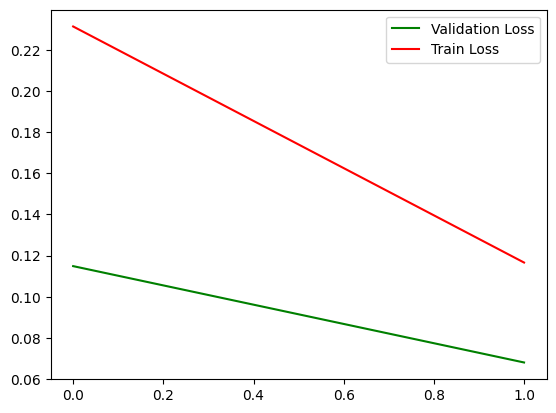

In [75]:
plt.plot(validation_running_loss_history, label = 'Validation Loss', color='green')
plt.plot(train_running_loss_history, label = 'Train Loss',  color='red')
plt.legend()

**We can see that both the losses are decreasing**

In [76]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [77]:
out = (y_pred + 0.5).int().float()

In [78]:
print(dice_coeff(y_train, out))
print("dice_loss: ",dice_loss(y_train, out))

0.9372222423553467
dice_loss:  0.06277775764465332


In [88]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transform_X=None):
        self.pixel_file = test_csv
        self.root_dir = root_dir
        self.transform_X = transform_X

    def __len__(self):
        return len(self.pixel_file)

    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, '', self.pixel_file.iloc[index, 0])

        imx = Image.open(imx_name)

        f_name = self.pixel_file.iloc[index, 0]

        if self.transform_X:
            imx = self.transform_X(imx)

        # Resize the image to a consistent size
        imx = transforms.Resize((540, 800))(imx)

        sample = {'image': imx, 'f_name': f_name}
        return sample


In [89]:
test_img = HC18_test('/content/drive/MyDrive/FinalProject/Dataset/test_set', transform_X = transform_X)

**Creating test-loader to work with test images**

In [90]:
test_loader = torch.utils.data.DataLoader(test_img, batch_size=batch_size,shuffle=False)

In [91]:
def avg_dice_index(dataloader):

    dice = 0.0
    model.eval()
    with torch.no_grad():

        for ith_batch, sample_batched in enumerate(dataloader):
            X_train , y_train = sample_batched
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            # print(model(X_train))

            y_predict = (model(X_train) + 0.5).int().float()
            # print(y_predict)

            dice += dice_coeff(y_predict, y_train)

    avg_dice = dice / len(dataloader)
    # print(avg_dice)
    return avg_dice

In [92]:
# import torch
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# def evaluate_and_print_results(model, test_loader, device):
#     model.eval()

#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((540, 800)),
#         transforms.ToTensor()
#     ])

#     with torch.no_grad():
#         for ith_batch, data in enumerate(test_loader):
#               X_test = data['image']
#               X_test = X_test.to(device)
#               y_pred = (model(X_test) + 0.5).int().float().cpu()
#               Result = transform(y_pred[0])

#               # Convert tensors to numpy arrays for visualization

#               y_pred_np = y_pred[0].cpu().numpy()

#               # Plot the images
#               plt.figure(figsize=(10, 4))
#               plt.subplot(1, 3, 1)
#               plt.imshow(X_test[0].permute(1, 2, 0).cpu().numpy())
#               plt.title('Input Image')

#               plt.subplot(1, 3, 3)
#               plt.imshow(y_pred_np[0], cmap='gray')
#               plt.title('Predicted Mask')

#               plt.show()

# # Example usage:
# evaluate_and_print_results(model, test_loader, device)

#Writing in the Drive

In [93]:
transform = transforms.Compose([
    transforms.Resize((540, 800)),  # Resize all images to a consistent size
    transforms.ToTensor()
])

with torch.no_grad():
    for ith_batch, data in enumerate(test_loader):
        X_test = data['image'].to(device)

        y_pred = (model(X_test) + 0.5).int().float().cpu()

        file_names = data['f_name']
        Result = y_pred[0]  # No need for additional transformations here
        torchvision.utils.save_image(Result, os.path.join('/content/drive/MyDrive/FinalProject/Dataset/segmentation_test_2/', file_names[0]))
    print("task to write file is complete")


task to write file is complete


**Function to create mask of test_set**

In [94]:
def test_ellipse(im):
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    # im2,
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse


# **Formula to Calculate Head Circumference**

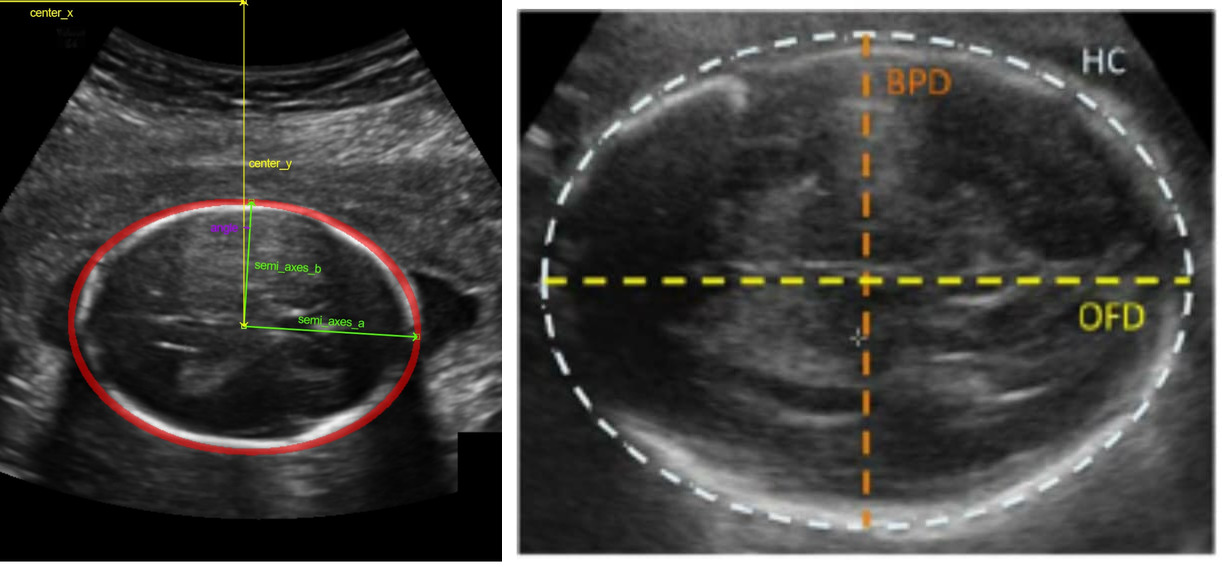

In [95]:
# occipitofrontal diameter (OFD)
#BPD (biparietal diameter), the diameter of your baby's head
#HC = 1.62 × (BPD + OFD) 3
# OFD = 2(semi_axes_a)
# BPD = 2(semi_axes_b)

#Creating a csv file to store the Data

In [97]:
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}



file_names = sorted([file for _,_,files in os.walk('/content/drive/MyDrive/FinalProject/Dataset/segmentation_test_2/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('/content/drive/MyDrive/FinalProject/Dataset/segmentation_test_2/'+file_name)

    ellipse = test_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1,100)

    # image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    # output_path = '/content/drive/MyDrive/FinalProject/Dataset/segmentation_test_masks/' # Change this to your desired output path
    # image_with_annotation_path = os.path.join(output_path, image_name)

    # cv2.imwrite(image_with_annotation_path, im_mask)

    pixel_size = test_csv.loc[test_csv['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    #OFD,  BPD = ellipse[3]
    #submission['OFD'].extend([semi_axes_a_mm*2])
    #submission['BPD'].extend([semi_axes_b*2])
    #submission['Head Circumfrence'].extend([1.62*(BPD + OFD)^3])
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm',
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("/content/drive/MyDrive/FinalProject/final1_result.csv", index=False)
print('Required .csv file generated')
print(ellipse)

Required .csv file generated
((295.1812744140625, 294.5733337402344), (408.25518798828125, 532.7623901367188), 82.88304138183594)


In [98]:
final_result = pd.read_csv('/content/drive/MyDrive/FinalProject/final1_result.csv')

In [ ]:
#HeadCircumfrence = 1.62*(BPD + OFD)^3
#HeadCircumfrence

In [99]:
final_result.head()

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,91.290576,63.875732,52.019236,39.788188,3.056987
1,001_HC.png,30.034970,22.115255,10.669495,8.335489,2.447694
2,002_HC.png,59.442596,42.406820,37.237152,28.748364,0.071383
3,003_HC.png,35.511302,27.393847,32.061124,22.748878,3.119328
4,004_HC.png,80.213513,58.368662,58.124270,43.318737,0.073559


In [ ]:
len(final_result)

##Caculating The Head Circumfrence

In [100]:
df = pd.read_csv("/content/drive/MyDrive/FinalProject/final1_result.csv")

In [101]:
df['OFD']= np.round(df.semi_axes_a_mm*2,1)

In [102]:
df['BPD']= np.round(df.semi_axes_b_mm*2,1)

In [103]:
b = np.round(df.BPD,1)

In [104]:
c= np.round(df.OFD,1)

In [105]:
d = b+c
e=d*d*d
f=(1.62*e)
g=np.round(f**(1/3),1)
h=g/10

In [106]:
df['Head_Circumfrence_cm']= h

In [107]:
df.head()

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad,OFD,BPD,Head_Circumfrence_cm
0,000_HC.png,91.290576,63.875732,52.019236,39.788188,3.056987,104.0,79.6,21.56
1,001_HC.png,30.034970,22.115255,10.669495,8.335489,2.447694,21.3,16.7,4.46
2,002_HC.png,59.442596,42.406820,37.237152,28.748364,0.071383,74.5,57.5,15.50
3,003_HC.png,35.511302,27.393847,32.061124,22.748878,3.119328,64.1,45.5,12.87
4,004_HC.png,80.213513,58.368662,58.124270,43.318737,0.073559,116.2,86.6,23.82


## Adding Gestational Age Data

In [108]:
import numpy as np
# Gestational Age
conditions = [
    (df['Head_Circumfrence_cm'] < 8.00),
    (df['Head_Circumfrence_cm'] >= 8.00) & (df['Head_Circumfrence_cm'] <= 9.00),#week13
    (df['Head_Circumfrence_cm'] > 9.01) & (df['Head_Circumfrence_cm'] <= 10.49),#week14
    (df['Head_Circumfrence_cm'] >10.50 ) & (df['Head_Circumfrence_cm'] <= 12.49),#week15
    (df['Head_Circumfrence_cm'] >12.50 ) & (df['Head_Circumfrence_cm'] <= 13.49),#week16
    (df['Head_Circumfrence_cm'] >13.50 ) & (df['Head_Circumfrence_cm'] <= 14.99),#week17
    (df['Head_Circumfrence_cm'] >15.00 ) & (df['Head_Circumfrence_cm'] <= 16.49),#week18
    (df['Head_Circumfrence_cm'] >16.50 ) & (df['Head_Circumfrence_cm'] <= 17.49),#week19
    (df['Head_Circumfrence_cm'] >17.50 ) & (df['Head_Circumfrence_cm'] <= 18.99),#week20
    (df['Head_Circumfrence_cm'] >19.00 ) & (df['Head_Circumfrence_cm'] <= 19.99),#week21
    (df['Head_Circumfrence_cm'] >20.00 ) & (df['Head_Circumfrence_cm'] <= 20.99),#week22
    (df['Head_Circumfrence_cm'] >21.00 ) & (df['Head_Circumfrence_cm'] <= 22.49),#week23
    (df['Head_Circumfrence_cm'] >22.50 ) & (df['Head_Circumfrence_cm'] <= 22.99),#week24
    (df['Head_Circumfrence_cm'] >= 23.00) & (df['Head_Circumfrence_cm'] <= 23.99),#week25
    (df['Head_Circumfrence_cm'] > 24.00) & (df['Head_Circumfrence_cm'] <= 24.79),#week26
    (df['Head_Circumfrence_cm'] >24.80 ) & (df['Head_Circumfrence_cm'] <= 25.60),#week27
    (df['Head_Circumfrence_cm'] >25.61 ) & (df['Head_Circumfrence_cm'] <= 26.75),#week28
    (df['Head_Circumfrence_cm'] >26.76 ) & (df['Head_Circumfrence_cm'] <= 27.75),#week29
    (df['Head_Circumfrence_cm'] >27.76 ) & (df['Head_Circumfrence_cm'] <= 28.85),#week30
    (df['Head_Circumfrence_cm'] >28.86 ) & (df['Head_Circumfrence_cm'] <= 29.60),#week31
    (df['Head_Circumfrence_cm'] >29.61 ) & (df['Head_Circumfrence_cm'] <= 30.40),#week32
    (df['Head_Circumfrence_cm'] >30.41 ) & (df['Head_Circumfrence_cm'] <= 31.20),#week33
    (df['Head_Circumfrence_cm'] >31.21 ) & (df['Head_Circumfrence_cm'] <= 31.80),#week34
    (df['Head_Circumfrence_cm'] >31.81 ) & (df['Head_Circumfrence_cm'] <= 32.50),#week35
    (df['Head_Circumfrence_cm'] >32.51 ) & (df['Head_Circumfrence_cm'] <= 33.00),#week36
    (df['Head_Circumfrence_cm'] >33.01 ) & (df['Head_Circumfrence_cm'] <= 33.70),#week37
    (df['Head_Circumfrence_cm'] >33.71 ) & (df['Head_Circumfrence_cm'] <= 34.20),#week38
    (df['Head_Circumfrence_cm'] >34.21 ) & (df['Head_Circumfrence_cm'] <= 35.00),#week39
    (df['Head_Circumfrence_cm'] >35.00 ) & (df['Head_Circumfrence_cm'] <= 36.00),#week40
    (df['Head_Circumfrence_cm'] > 36)
    ]

# create a list of the values we want to assign for each condition
values = ['Fetus is less than 8 Menstrual Weeks','13','14','15','16','17','18','19','20','21','22',
          '23','24','25', '26', '27', '28','29','30','31','32','33','34','35','36','37','38','39','40','Abnormal']


df['Gestational_Age_In_Weeks'] = np.select(conditions, values)


df.head(10)

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad,OFD,BPD,Head_Circumfrence_cm,Gestational_Age_In_Weeks
0,000_HC.png,91.290576,63.875732,52.019236,39.788188,3.056987,104.0,79.6,21.56,23
1,001_HC.png,30.034970,22.115255,10.669495,8.335489,2.447694,21.3,16.7,4.46,Fetus is less than 8 Menstrual Weeks
2,002_HC.png,59.442596,42.406820,37.237152,28.748364,0.071383,74.5,57.5,15.50,18
3,003_HC.png,35.511302,27.393847,32.061124,22.748878,3.119328,64.1,45.5,12.87,16
4,004_HC.png,80.213513,58.368662,58.124270,43.318737,0.073559,116.2,86.6,23.82,25
5,005_HC.png,48.711746,28.929641,29.995863,24.070386,3.031886,60.0,48.1,12.70,16
6,006_HC.png,54.641918,35.907822,36.298286,27.857693,0.018576,72.6,55.7,15.07,18
7,007_HC.png,57.479030,39.218653,34.536065,28.960026,0.184153,69.1,57.9,14.92,17
8,008_HC.png,49.607451,42.808210,24.775848,16.615976,2.883837,49.6,33.2,9.72,14
9,009_HC.png,137.003546,99.236680,57.495439,47.291025,2.696338,115.0,94.6,24.62,26


In [109]:
df.to_csv("/content/drive/MyDrive/FinalProject/Head_Circumfrence.csv")

In [110]:
def check_age(age):
    try:
        age = int(age)
        if age >= 22:
            return True
    except ValueError:
        pass
    return False

def is_valid_image(data, file_name):
    image_name = file_name
    selected_data = data[data['filename'] == image_name]
    age = selected_data["Gestational_Age_In_Weeks"].iloc[0]  # Assuming there is only one matching row
    return check_age(age)


In [111]:
import pandas as pd


def return_age(data, file_name):
    image_name = file_name
    selected_data = data[data['filename'] == image_name]
    age = selected_data["Gestational_Age_In_Weeks"].iloc[0]  # Assuming there is only one matching row
    return age


In [112]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)

    return iou

def calculate_average_iou(gt_dir, pred_dir, csv_path):
    gt_files = sorted([file for _, _, files in os.walk(gt_dir) for file in files])
    pred_files = sorted([file for _, _, files in os.walk(pred_dir) for file in files])

    total_iou = 0.0
    counter = 0

    # Read CSV file once
    data = pd.read_csv(csv_path)

    for gt_file, pred_file in zip(gt_files, pred_files):
        if is_valid_image(data, pred_file):
            gt_path = os.path.join(gt_dir, gt_file)
            pred_path = os.path.join(pred_dir, pred_file)

            gt_image = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
            pred_image = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

            # Convert images to binary masks
            gt_mask = (gt_image > 0).astype(np.uint8)
            pred_mask = (pred_image > 0).astype(np.uint8)

            iou = calculate_iou(gt_mask, pred_mask)
            total_iou += iou
            age = return_age(data, pred_file)
            print(f"IoU for {pred_file}, age: {age}: {iou}")
            counter += 1

    if counter > 0:
        average_iou = total_iou / counter
        print(f"Average IoU: {average_iou}")
    else:
        print("No valid images found.")

# Example usage:

ground_truth_dir = '/content/drive/MyDrive/FinalProject/Dataset/segmentation_test_masks/'
prediction_dir = '/content/drive/MyDrive/FinalProject/Dataset/segmentation_test_2/'
csv_path = "/content/drive/MyDrive/FinalProject/Head_Circumfrence.csv"

calculate_average_iou(ground_truth_dir, prediction_dir, csv_path)


IoU for 000_HC.png, age: 23: 0.9150853026164747
IoU for 004_HC.png, age: 25: 0.9391151529800391
IoU for 009_HC.png, age: 26: 0.8811837637970612
IoU for 036_HC.png, age: 23: 0.9536951732425396
IoU for 039_HC.png, age: 22: 0.8937043739459074
IoU for 043_HC.png, age: 23: 0.8573956709255472
IoU for 050_HC.png, age: 23: 0.9424474045239205
IoU for 064_HC.png, age: 25: 0.9296003316176724
IoU for 068_HC.png, age: 24: 0.9392373205096515
IoU for 087_HC.png, age: 23: 0.9672589438497353
IoU for 088_HC.png, age: 25: 0.9445650508249477
IoU for 151_HC.png, age: 23: 0.8217864191827993
IoU for 152_HC.png, age: 25: 0.9604697679275748
IoU for 162_HC.png, age: 23: 0.8605768019814449
IoU for 174_HC.png, age: 25: 0.9355970362605422
IoU for 183_HC.png, age: 23: 0.8945448905641223
IoU for 192_HC.png, age: 23: 0.9324919728861933
IoU for 208_HC.png, age: 26: 0.7865177592986528
IoU for 211_HC.png, age: 23: 0.7944975840646878
IoU for 241_HC.png, age: 22: 0.7357912290981206
IoU for 244_HC.png, age: 23: 0.919317400